## Motivation

Very similar to [our discussion on using QQ plots to check the Normality of your data](https://napsterinblue.github.io/notes/stats/basics/qq_plots/), Calibration Curves are used to check the quantile relationship between your predictions and the underlying values they try to predict.

So what does that mean?

Recall that nearly all implementations of our Classifiers actually output a *probability* under the hood, which is compared against some threshold to make our decisions. Now imagine sorting all of those probability values, smallest to largest. If our model was "well-calibrated", we should expect to see some reliable patterns when we examine these sorted values, by quantile.

Concretely, if we look at records found in the first 10% of probabilities, the average predicted probability *should* be consistent with the percent of positive records in this sample. Similarly for the 10-20th percentile, and the 20-30th, etc, etc.

## In sklearn

`sklearn` has a helpful utility function, `calibration_curve()`, that allows us to examine these relationships quickly. The code is largely lifted from [their docs](https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py), with my own commentary.

For the sake of example, let's generate a fake dataset comprised of 10k records and of the 20 features, 2 are useful and 2 aren't.

In [1]:
%pylab inline

np.random.seed(0)

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import datasets

X, y = datasets.make_classification(
    n_samples=10000, n_features=20, n_informative=2, n_redundant=2
)

Populating the interactive namespace from numpy and matplotlib


As you can see, the breakout of `0/1` values is very nearly 50/50

In [2]:
from collections import Counter

Counter(y)

Counter({1: 5008, 0: 4992})

### Simple Case

And so splitting out the data like we usually do

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7,
                                                    test_size=.3, random_state=42)

We'll fit a Logistic Regression to our training data

In [4]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train);

Which yields an average predicted value just a bit south of 50/50, which is ideal because it lines up with our `0/1` distribution

In [5]:
y_train.mean()

0.49228571428571427

Now we'll express our predictions in terms of `Pr(True)` and feed it into `calibration_curve()` along with the correct values of `y_train`.

In [6]:
from sklearn.calibration import calibration_curve

n_bins = 10
prob_true = lr.predict_proba(X_train)[:, 1] # results are tuples of (Pr(False), Pr(True))
fraction_of_positives, mean_predicted_value = calibration_curve(y_train, prob_true, n_bins=n_bins)

This `n_bins` argument is important, because it determines how granularly we examine the quantiles to check "average prediction" vs "proportion of True records."

Under the hood, the function defaults to creating uniform bins between `0` and `1`

In [7]:
bins = np.linspace(0.0, 1.0 + 1e-8, n_bins + 1)
print(bins)

[0.         0.1        0.2        0.3        0.4        0.5
 0.60000001 0.70000001 0.80000001 0.90000001 1.00000001]


And so as a sanity check, we'll use these bins to interrogate the returned values of `fraction_of_positives`.

The first bin is in the range `(0, 0.1]`, so we'll filter down all of our probability predictions within that band. Then use that index to filter down our `y_train` records. Finally, taking the mean of what's left gives us the proportion of `True` records in the first quantile.

In [8]:
y_train[prob_true <= .1].mean()

0.054071661237785014

In [9]:
fraction_of_positives[0]

0.054071661237785014

The same relationship holds for the next bin

In [10]:
y_train[(0.1 < prob_true) & (prob_true <= 0.2)].mean()

0.1181959564541213

In [11]:
fraction_of_positives[1]

0.1181959564541213

and so on...

In [12]:
fraction_of_positives

array([0.05407166, 0.11819596, 0.21372549, 0.33595801, 0.41899441,
       0.51815981, 0.66287016, 0.78496241, 0.87447699, 0.94272727])

Similarly, we want to look at these same cuts, and see *what our average predicted value is*.

In [13]:
mean_predicted_value

array([0.04023254, 0.14607538, 0.24808382, 0.34888665, 0.4520183 ,
       0.54961305, 0.65147235, 0.75068661, 0.8530717 , 0.94677561])

In [14]:
prob_true[prob_true <= 0.1].mean()

0.040232536676567954

In [15]:
prob_true[(0.1 < prob_true) & (prob_true <= 0.2)].mean()

0.14607538336214732

### Creating the Plots

And so taking these 10 quantile observations and plotting them against one another, we can see a roughly-linear relationship forming. The orange, dashed line represents the perfect relationship where our predictions line up 1-1 with the proportion of positive records.

Couple caveats here, we should expect a Logistic Regression to produce a pretty straight line-- after all, the underling mechanism is a linear one.

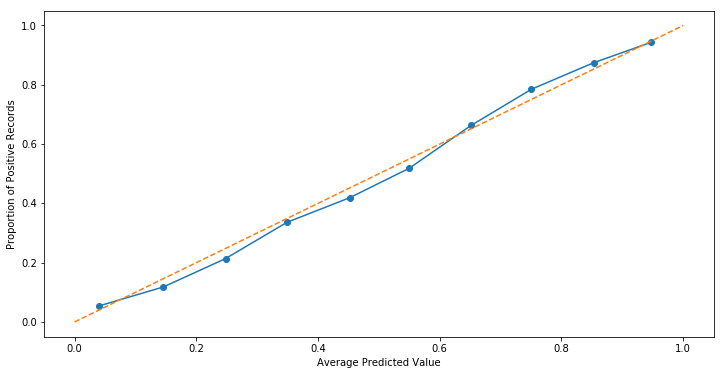

In [16]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_train, prob_true, n_bins=10)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(mean_predicted_value, fraction_of_positives, marker='o')
ax.set_xlabel('Average Predicted Value')
ax.set_ylabel('Proportion of Positive Records')
ax.plot([0, 1], [0, 1], linestyle='--');

However, increasing the number of bins from 10 to 50 reveals that intra-bin errors were more or less cancelling each other out.

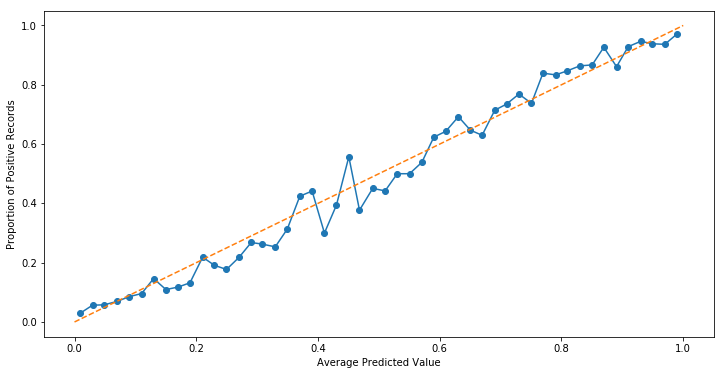

In [17]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_train, prob_true, n_bins=50)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(mean_predicted_value, fraction_of_positives, marker='o')
ax.set_xlabel('Average Predicted Value')
ax.set_ylabel('Proportion of Positive Records')
ax.plot([0, 1], [0, 1], linestyle='--');

Indeed, when we look at a histogram of predicted probabilities, the "above the dotted line" bit between `(0, 0.05]` makes sense, as our model has a bias of predicting values very close to zero.

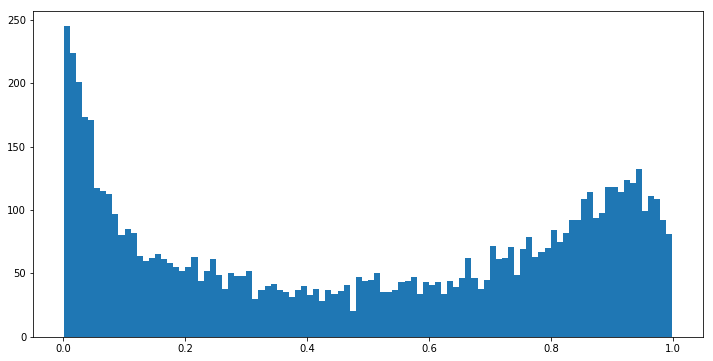

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(prob_true, bins=100);

Overall, despite being well-calibrated (hugging the dotted line pretty nicely), our model has room for improvements by most measures of accuracy.

In [19]:
from sklearn.metrics.classification import confusion_matrix

confusion_matrix(y_test, lr.predict(X_test))

array([[1189,  249],
       [ 277, 1285]], dtype=int64)

Compare that to a Random Forest approach trained on the same data

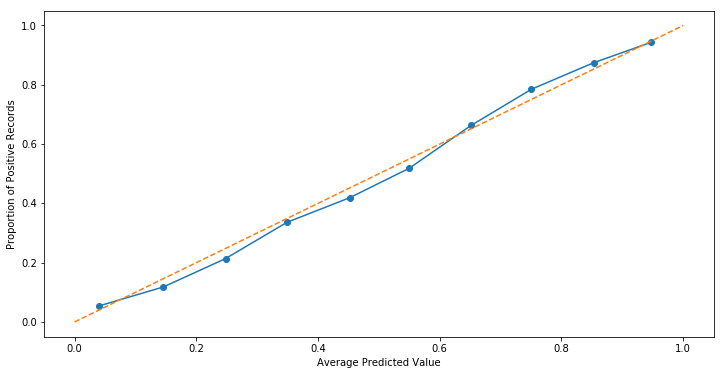

In [20]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train);

fraction_of_positives, mean_predicted_value = calibration_curve(y_train, prob_true, n_bins=10)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(mean_predicted_value, fraction_of_positives, marker='o')
ax.set_xlabel('Average Predicted Value')
ax.set_ylabel('Proportion of Positive Records')
ax.plot([0, 1], [0, 1], linestyle='--');

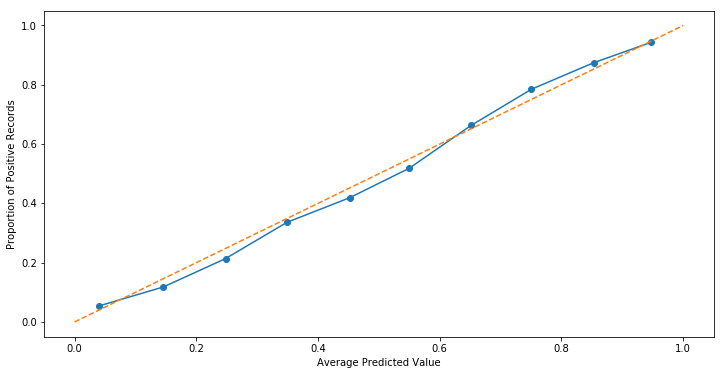

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(mean_predicted_value, fraction_of_positives, marker='o')
ax.set_xlabel('Average Predicted Value')
ax.set_ylabel('Proportion of Positive Records')
ax.plot([0, 1], [0, 1], linestyle='--');

Looking at the histogram of predicted probabilities, the majority of our values are very close to `0` or `1`. This should track, because tree-based methods don't really have a clean notion of "continuum."

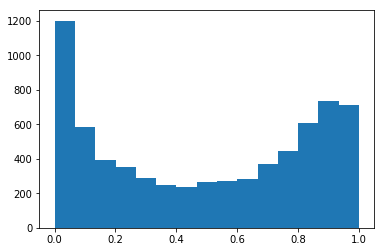

In [22]:
plt.hist(prob_true, bins=15);

Instead, it more-accurately sorts the data than its Logistic counterpart

In [23]:
confusion_matrix(y_test, rfc.predict(X_test))

array([[1294,  144],
       [ 180, 1382]], dtype=int64)

Which brings us to the conversation of when to use this tool.

## Interpretation

I came across Calibration Plots reading the book [Building ML Powered Applications](https://github.com/hundredblocks/ml-powered-applications/blob/master/ml_editor/model_evaluation.py#L153), and in the example the author put forward, we wanted to create a feedback loop between model and user, such that they could reliably "hill climb" to a high score by making minor edits to their inputs.

In the image below, the author compares and contrasts three such models.

Not pictured here, but from an accuracy standpoint the hierarchy of models was 2 > 1 > 3. Nevertheless, they were most interested in going with Model 3, because the product they were building was more focused on model interpretability than accuracy measures.

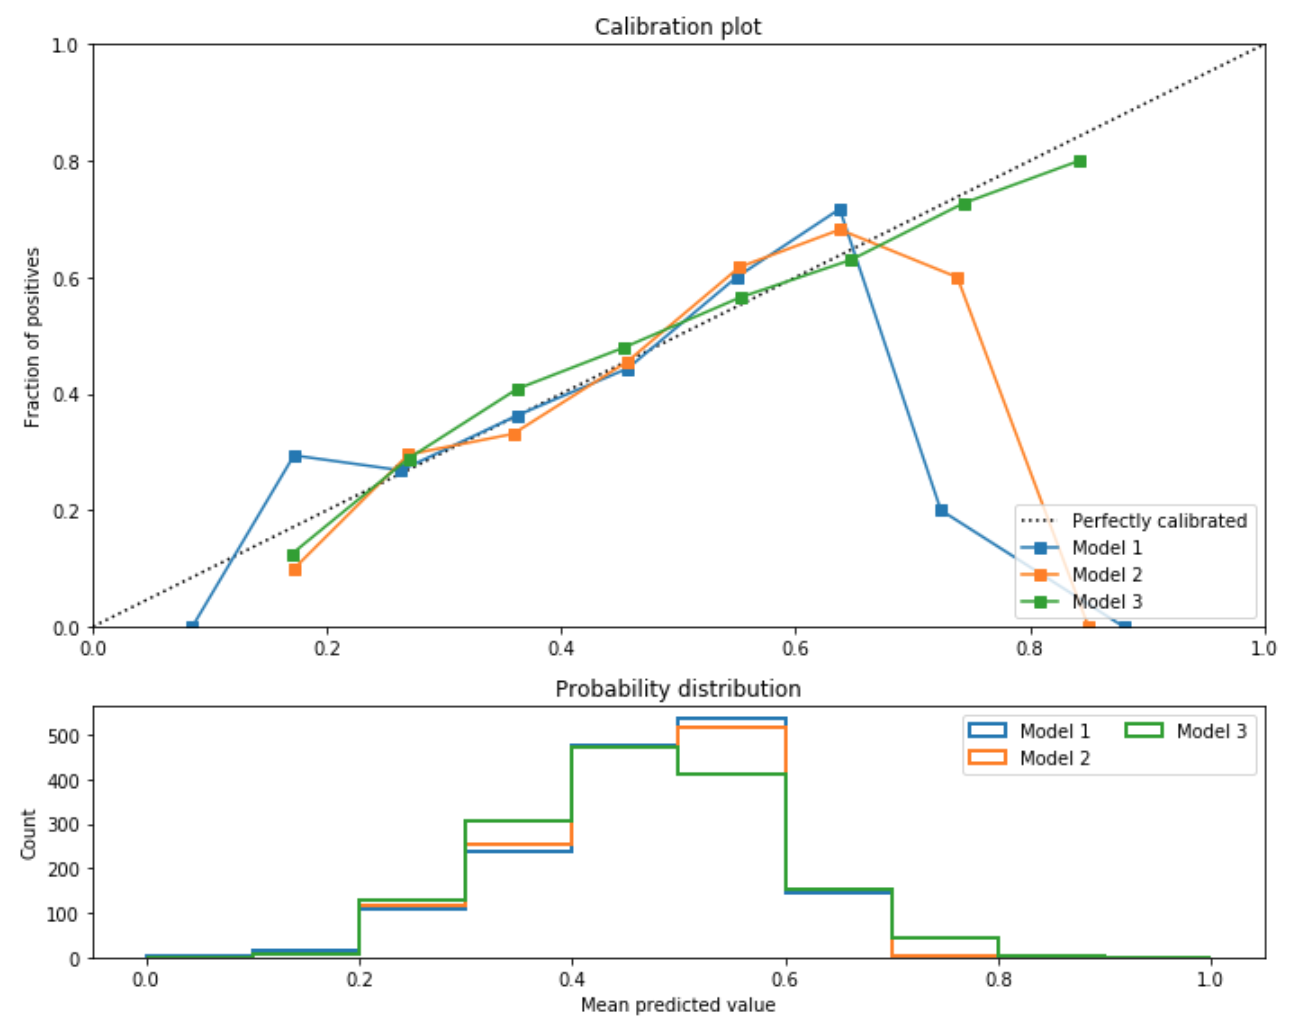

In [24]:
from IPython.display import Image

Image('images/calibration.png')